# Méthodes de simulation de l'impact d'une réforme sur le budget de l'Etat

In [1]:
# default_exp csg_simu

In [2]:
#!poetry run pip list | grep -i open

In [3]:
# Activate multi-output in notebook
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [4]:
# export
# For profiling of code
import timeit

In [5]:
log_run = False
debut_global = timeit.default_timer()

In [6]:
# export

import hashlib
import json
import unittest

# import warnings
from typing import Dict, List

import numpy as np
import pandas as pd
from openfisca_core import periods

# from openfisca_core.memory_config import MemoryConfig
from openfisca_core.parameters import ParameterNode, ParameterScaleBracket, helpers
from openfisca_core.periods import instant
from openfisca_core.simulation_builder import SimulationBuilder
from openfisca_core.taxbenefitsystems import TaxBenefitSystem  # For typing

# from openfisca_core.warnings import MemoryConfigWarning, TempfileWarning
from openfisca_france import FranceTaxBenefitSystem
from openfisca_france.model.base import Reform
from openfisca_france_reforms.plf_2022 import Plf2022

from leximpact_socio_fisca_simu_etat.aggregates_read import get_aggregate
from leximpact_socio_fisca_simu_etat.cache import Cache
from leximpact_socio_fisca_simu_etat.config import Configuration
from leximpact_socio_fisca_simu_etat.logger import logger
from leximpact_socio_fisca_simu_etat.schema import (
    AllSimulationResult,
    OneSimulationResult,
    ReformeSocioFiscale,
)

plf_2022 = Plf2022(FranceTaxBenefitSystem())

config = Configuration()
cache = Cache()
tc = unittest.TestCase()

[leximpact_socio-fisca-simu-etat DEBUG @ 15:09:22] Connecting to Redis 10.0.0.131:6377


In [7]:
import os

import matplotlib as mpl
import psutil
import seaborn as sns

# from memory_profiler import memory_usage
# import tracemalloc
# tracemalloc.start(10)

In [8]:
pd.options.display.float_format = "{:,.7f}".format
sns.set(rc={"figure.figsize": (20, 8)})

In [9]:
# hide
cache.clear_cache()

[leximpact_socio-fisca-simu-etat DEBUG @ 15:09:22] Redis cache cleared successfully.


True

In [10]:
# export


class SimulationError(Exception):
    """Custom error"""

    pass

## Chargement du fichier d'individus OpenFisca
Préparé à partir de l'ERFS-FPR 2018 et des copules POTE

In [11]:
# config.get("ERFS_FINAL_FOR_SIMU")

In [12]:
# export

inputfile_path = config.get("ERFS_FINAL_FOR_SIMU")
# inputfile_path = config.get("ERFS_FINAL_FOR_SIMU_PLF_2022")
sample_pop = pd.read_hdf(inputfile_path)

In [13]:
sample_pop.columns

Index(['idfoy', 'age', 'categorie_salarie', 'contrat_de_travail',
       'date_naissance', 'quifam', 'quifoy', 'statut_marital', 'quimenof',
       'quifoyof', 'quifamof', 'wprm', 'fake_id', 'activite', 'chomage_brut',
       'effectif_entreprise', 'heures_remunerees_volume', 'idfam', 'idmen',
       'noindiv', 'pensions_alimentaires_percues', 'quimen', 'rag',
       'retraite_brute', 'ric', 'rnc', 'salaire_de_base', 'f4ba',
       'idmen_original', 'idfoy_original', 'idfam_original', 'idmen_x',
       'loyer', 'statut_occupation_logement', 'taxe_habitation', 'zone_apl',
       'rfr', 'revenus_capitaux_prelevement_bareme',
       'revenus_capitaux_prelevement_liberatoire',
       'revenus_capitaux_prelevement_forfaitaire_unique_ir',
       'salaire_imposable'],
      dtype='object')

In [14]:
# export
for v in [
    "assiette_csg_abattue",
    "assiette_csg_non_abattue",
    "csg_imposable_salaire",
    "csg_deductible_salaire",
    "csg_imposable_retraite",
    "csg_deductible_retraite",
    "csg_imposable_chomage",
    "csg_deductible_chomage",
    "csg_revenus_capital",
    "crds_salaire",
    "crds_retraite",
    "crds_chomage",
    "crds_revenus_capital",
    "irpp",
]:
    tc.assertFalse(
        v in sample_pop.columns,
        f"FATAL : {v} is in the input dataset, please remove output variables from the input dataset !",
    )

In [15]:
# sample_pop.query("salaire_de_base == 9_999_998")  # Pour vérifier les codes erreurs INSEE

In [16]:
# df_tmp = pd.read_hdf("/mnt/data-out/leximpact/erfs-fpr/erfs_flat_2018.h5")
# nb_sans_salaire = df_tmp.query("salaire_de_base < 1").wprm.sum()
# nb_avec_salaire = df_tmp.query("salaire_de_base >= 1").wprm.sum()
# print(
#     f"Il y a {nb_sans_salaire:,.0f} personnes sur {df_tmp.wprm.sum():,.0f} qui n'ont pas de salaire, soit {nb_sans_salaire/(nb_sans_salaire+nb_avec_salaire)*100:.0f}%."
# )
# nb_avec_salaire

In [17]:
# # POTE
# 15592390 / (15592390 + 22895547) * 100

In [18]:
# nb_sans_salaire = sample_pop.query("salaire_de_base < 1").wprm.sum()
# nb_avec_salaire = sample_pop.query("salaire_de_base >= 1").wprm.sum()
# print(
#     f"Il y a {nb_sans_salaire:,.0f} personnes sur {sample_pop.wprm.sum():,.0f} qui n'ont pas de salaire, soit {nb_sans_salaire/(nb_sans_salaire+nb_avec_salaire)*100:.0f}%."
# )
# nb_avec_salaire

In [19]:
# export


def convert_erfr_to_openfisca(data):
    """
    # Conversion des noms ERFS en noms  OpenFisca
    Traduction des roles attribués au format openfisca
    ::data:: Le dataset à convertir
    """
    data["quimenof"] = "enfant"
    data.loc[data["quifoy"] == 1, "quimenof"] = "conjoint"
    data.loc[data["quifoy"] == 0, "quimenof"] = "personne_de_reference"

    data["quifoyof"] = "personne_a_charge"
    data.loc[data["quifoy"] == 1, "quifoyof"] = "conjoint"
    data.loc[data["quifoy"] == 0, "quifoyof"] = "declarant_principal"

    data["quifamof"] = "enfant"
    data.loc[data["quifam"] == 1, "quifamof"] = "conjoint"
    data.loc[data["quifam"] == 0, "quifamof"] = "demandeur"
    return data

In [20]:
# export

sample_pop = convert_erfr_to_openfisca(sample_pop)

In [21]:
# export


def individus_to_foyer_fiscaux(sample_individus):
    """
    Regroupe un échantillon par individus en échantillon par foyers fiscaux
    """
    # On regroupe les individus de sample_pop_individus en foyers fiscaux par leur idfoy
    sample_foyers_fiscaux = sample_individus.groupby(
        ["idfoy", "wprm"], as_index=False
    ).sum()
    # On supprime les colonnes qui n'ont plus de sens au niveau foyer
    sample_foyers_fiscaux.drop(
        [
            "quifoy",
            "quifam",
            "age",
            "categorie_salarie",
            "contrat_de_travail",
            "statut_marital",
        ],
        axis=1,
        inplace=True,
    )

    return sample_foyers_fiscaux

In [22]:
# export

sample_pop_foyer = individus_to_foyer_fiscaux(sample_pop)

In [23]:
sample_pop.describe()

,idfoy,age,categorie_salarie,contrat_de_travail,quifam,quifoy,statut_marital,wprm,fake_id,activite,...,idmen_x,loyer,statut_occupation_logement,taxe_habitation,zone_apl,rfr,revenus_capitaux_prelevement_bareme,revenus_capitaux_prelevement_liberatoire,revenus_capitaux_prelevement_forfaitaire_unique_ir,salaire_imposable
count,"336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000",...,"336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000","336,402.0000000"
mean,"85,397.8407709",42.3438743,4.3804644,3.6372911,0.7331140,0.7331140,1.7978133,199.6306230,0.6666667,3.9169476,...,"48,026,923.8539158",0.0000000,0.0000000,0.0000000,5.3286604,"14,478.2705078",112.2462897,167.8192584,"1,550.2641816","8,591.7177734"
std,"49,294.7910630",24.4341202,3.2467432,2.7982572,0.8229703,0.8229703,0.8115791,140.6775240,0.4714052,2.8594901,...,"25,547,146.0209368",0.0000000,0.0000000,0.0000000,2.8345250,"44,364.4726562","3,888.9626460","5,814.3821864","53,711.5258713","23,242.1875000"
min,0.0000000,-1.0000000,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000,11.1806653,0.0000000,0.0000000,...,"18,000,001.0000000",0.0000000,0.0000000,0.0000000,2.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
25%,"42,651.0000000",20.0000000,0.0000000,0.0000000,0.0000000,0.0000000,1.0000000,136.1408387,0.0000000,2.0000000,...,"36,007,780.0000000",0.0000000,0.0000000,0.0000000,4.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
50%,"85,376.0000000",44.0000000,7.0000000,6.0000000,0.0000000,0.0000000,2.0000000,172.2093207,1.0000000,4.0000000,...,"36,084,898.0000000",0.0000000,0.0000000,0.0000000,4.0000000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000000
75%,"128,138.0000000",62.0000000,7.0000000,6.0000000,1.0000000,1.0000000,2.0000000,221.7150802,1.0000000,6.0000000,...,"72,048,964.0000000",0.0000000,0.0000000,0.0000000,8.0000000,"21,252.7871094",0.0000000,0.0000000,0.0000000,"2,897.3546143"
max,"170,804.0000000",106.0000000,7.0000000,6.0000000,2.0000000,2.0000000,4.0000000,"3,884.7876733",1.0000000,27.0000000,...,"216,377,964.0000000",0.0000000,0.0000000,0.0000000,24.0000000,"10,002,557.0000000","1,518,597.5999320","2,270,452.9811851","20,973,766.4517848","2,275,579.7500000"


In [24]:
sample_pop.columns

Index(['idfoy', 'age', 'categorie_salarie', 'contrat_de_travail',
       'date_naissance', 'quifam', 'quifoy', 'statut_marital', 'quimenof',
       'quifoyof', 'quifamof', 'wprm', 'fake_id', 'activite', 'chomage_brut',
       'effectif_entreprise', 'heures_remunerees_volume', 'idfam', 'idmen',
       'noindiv', 'pensions_alimentaires_percues', 'quimen', 'rag',
       'retraite_brute', 'ric', 'rnc', 'salaire_de_base', 'f4ba',
       'idmen_original', 'idfoy_original', 'idfam_original', 'idmen_x',
       'loyer', 'statut_occupation_logement', 'taxe_habitation', 'zone_apl',
       'rfr', 'revenus_capitaux_prelevement_bareme',
       'revenus_capitaux_prelevement_liberatoire',
       'revenus_capitaux_prelevement_forfaitaire_unique_ir',
       'salaire_imposable'],
      dtype='object')

## Vérifications

In [25]:
somme_des_rfr = (sample_pop["rfr"] * sample_pop["wprm"]).sum()
print(f"somme_des_rfr = {somme_des_rfr:,.0f} €")
tc.assertGreater(abs(somme_des_rfr), 600_000_000_000)
tc.assertLess(abs(somme_des_rfr), 1_500_000_000_000)
tc.assertGreater(len(sample_pop), 116_861)

somme_des_rfr = 992,379,535,371 €


In [26]:
# export
# sample_pop_foyer = pd.read_csv(config["DATA_OUT"] + "sample_pop_ff_csg.csv")
# annee_de_calcul = "2021"

In [27]:
# tc.assertLess( abs(sample_pop_foyer["rfr"].mean() - 26_897) , 10 )

## Prépare la simulation

**TODO:** Le faire une fois pour toute au démarrage.
Attention, ce n'est pas simple car il y a à l'intérieur la création du SimulationBuilder

In [28]:
# export

# Remove warnings about using disk cache in case of Out of Memory
# warnings.simplefilter(action="ignore", category=MemoryConfigWarning)
# warnings.simplefilter(action="ignore", category=TempfileWarning)


def create_simulation(period: str, data: pd.DataFrame, tbs: TaxBenefitSystem):
    # Vient de LexImpact Server simulate_pop_from_reform-> simulation
    sb = SimulationBuilder()
    sb.create_entities(tbs)

    sb.declare_person_entity("individu", data.index)

    # Creates openfisca entities and generates grouped

    listentities = {"foy": "foyer_fiscal", "men": "menage", "fam": "famille"}

    instances = {}
    dictionnaire_datagrouped = {"individu": data}

    for ent, ofent in listentities.items():
        persons_ent = data["id" + ent].values
        persons_ent_roles = data["qui" + ent + "of"].values
        ent_ids = data["id" + ent].unique()
        instances[ofent] = sb.declare_entity(ofent, ent_ids)
        sb.join_with_persons(instances[ofent], persons_ent, roles=persons_ent_roles)

        # The following ssumes data defined for an entity are the same for all rows in
        # the same entity. Or at least that the first non null value found for an
        # entity will always be the total value for an entity (which is the case for
        # f4ba). These checks are performed in the checkdata function defined below.
        dictionnaire_datagrouped[ofent] = (
            data.groupby("id" + ent, as_index=False).first().sort_values(by="id" + ent)
        )

    # These variables should not be attributed to any OpenFisca Entity
    columns_not_OF_variables = {
        "idmen",
        "idfoy",
        "idfam",
        "noindiv",
        "level_0",
        "quifam",
        "quifoy",
        "quimen",
        "idmen_x",
        "idmen_y",
        "wprm",
        "index",
        "idmen_original",
        "idfoy_original",
        "idfam_original",
        "quifamof",
        "quifoyof",
        "quimenof",
        "assiette_csg_plus_values",
        "csg_deductible_chomage",
        "csg_imposable_chomage",
        "csg_chomage",
        "csg_deductible_retraite",
        "csg_imposable_retraite",
        "csg_retraite",
        "pote_rev_capital",
        "pote_rente_viagere",
        "pote_rev_categ_foncier",
        "pote_plus_values",
        "pote_chomage",
        "pote_retraite",
        "pote_pre-retraite",
        "fake_id",
        "taux_csg_remplacement",
    }

    simulation = sb.build(tbs)
    #     memory_config = MemoryConfig(
    #         max_memory_occupation=0.95,  # When 95% of the virtual memory is full, switch to disk storage
    #         priority_variables=["salary", "age"],  # Always store these variables in memory
    #         # variables_to_drop=non_cached_variables,
    #     )
    #     simulation.memory_config = memory_config

    # Attribution des variables à la bonne entité OpenFisca
    for colonne in data.columns:
        # On entre les valeurs sur les 3 dernieres annees (par exemple pour calculer la retraite)
        for year in range(int(period) - 2, int(period) + 1):
            if colonne not in columns_not_OF_variables:
                try:
                    # print("colonne", colonne)
                    simulation.set_input(
                        colonne,
                        str(year),
                        dictionnaire_datagrouped[tbs.get_variable(colonne).entity.key][
                            colonne
                        ],
                    )
                except AttributeError as e:
                    print(
                        f"AttributeError, are you sure {colonne} is known by your OpenFisca TaxBenefitSystem ? {e}"
                    )
                    raise e

    return simulation, dictionnaire_datagrouped

## Prépare la réforme

On utilise OpenFisca pour appliquer une réforme.

Ici on hérite de la class Reform et on lui applique la réforme souhaitée.

In [29]:
# export
class CustomReform(Reform):
    """
    Override the OpenFisca Reform class
    """

    def __init__(
        self, tbs: TaxBenefitSystem, payload: ReformeSocioFiscale, period: str
    ) -> None:
        self.payload = payload
        self.instant = periods.instant(period)
        self.period = periods.period("year:1900:200")
        super().__init__(tbs)

    def modifier(self, parameters: ParameterNode) -> ParameterNode:
        # openfisca-france/openfisca_france/parameters/prelevements_sociaux/contributions_sociales/csg/
        if self.payload.amendement is None:
            return parameters
        for parameter_name, change in self.payload.amendement.items():
            # On itère sur chaque partie du nom du paramètre en str pour en faire un ParameterNode conforme
            parameter = parameters
            for sub_name in parameter_name.split("."):
                parameter = parameter.children[sub_name]
            # Si la valeur est un dictionnaire, alors on a affaire à un barème
            if isinstance(change, Dict):
                if change["type"] == "parameter":
                    taux = change["value"]
                    parameter.update(
                        start=instant(change.get("start")),
                        stop=instant(change.get("stop")),
                        value=taux,
                    )
                elif change["type"] == "scale":
                    # ### Debut du copier-coller de https://git.leximpact.dev/leximpact/leximpact-socio-fiscal-api/-/blob/master/leximpact_socio_fiscal_api/routers/simulations.py#L62
                    # TODO: handle stop?.
                    if change.get("stop") is not None:
                        print("Scale change can't contain a 'stop'")
                        break
                    # Note: change has the form:
                    # {
                    #     'scale': [
                    #         {'rate': {'value': 0.5}, 'threshold': {'value': 0}},
                    #         {'rate': {'value': 0}, 'threshold': {'value': 4}},
                    #     ],
                    #     'start': '2021-01-01',
                    #     'type': 'scale',
                    # }
                    # This is not the same structure as OpenFisca brackets
                    # => Convert it.
                    brackets = parameter.brackets
                    value_key = (
                        "amount"
                        if any("amount" in bracket.children for bracket in brackets)
                        else "average_rate"
                        if any(
                            "average_rate" in bracket.children for bracket in brackets
                        )
                        else "rate"
                    )

                    brackets_change = []
                    for bracket in change["scale"]:
                        bracket_change = {}

                        threshold = bracket["threshold"]
                        if threshold == "expected":
                            logger.error(
                                "Brackets with 'expected' values are not supported."
                            )
                            break
                        value = threshold["value"]
                        if value is None:
                            # Ignore brackets with a null threshold.
                            continue
                        bracket_change["threshold"] = value

                        if value_key == "amount":
                            amount = bracket["amount"]
                            if amount == "expected":
                                logger.error(
                                    "Brackets with 'expected' values are not supported."
                                )
                                break
                            bracket_change["amount"] = amount["value"]
                        elif value_key == "average_rate":
                            rate = bracket["rate"]
                            if rate == "expected":
                                logger.error(
                                    "Brackets with 'expected' values are not supported."
                                )
                                break
                            bracket_change["average_rate"] = rate["value"]
                        else:
                            base = bracket.get("base")
                            if base is not None:
                                if base == "expected":
                                    logger.error(
                                        "Brackets with 'expected' values are not supported."
                                    )
                                    break
                                bracket_change["base"] = base["value"]
                            rate = bracket["rate"]
                            if rate == "expected":
                                logger.error(
                                    "Brackets with 'expected' values are not supported."
                                )
                                break
                            bracket_change["rate"] = rate["value"]
                        brackets_change.append(bracket_change)
                    else:
                        # Brackets change contains no error.
                        brackets_change.sort(
                            key=lambda bracket_change: bracket_change["threshold"]
                        )
                        start = change["start"]
                        for index, bracket_change in enumerate(brackets_change):
                            if len(brackets) <= index:
                                brackets.append(
                                    ParameterScaleBracket(
                                        name=helpers._compose_name(
                                            parameter.name, item_name=index
                                        ),
                                        data={
                                            key: {start: value_change}
                                            for key, value_change in bracket_change.items()
                                        },
                                    )
                                )
                            else:
                                bracket_dict = brackets[index].children
                                for key, value_change in bracket_change.items():
                                    value = bracket_dict.get(key)
                                    if value is None:
                                        bracket_dict[key] = dict(
                                            start=instant(start),
                                            value=value_change,
                                        )
                                    else:
                                        value.update(
                                            start=instant(start),
                                            value=value_change,
                                        )
                        if len(brackets) > len(brackets_change):
                            del brackets[len(brackets_change) :]
                # #### Fin du copier-coller
                else:
                    logger.error(
                        f'Parameter type {value["type"]} not yet implemented in our API.'
                    )
                    # TODO : raise exception ?
                # print(parameter.brackets[0].children['rate'].__dict__)
            else:
                # Si ce n'est pas un barème, on update la valeur du paramètre
                parameter.update(period=self.period, value=change)
            # logger.debug(f"CustomReform.modifier parameter {parameter_name} for {self.period} after update : {parameter}",)
        return parameters

    def apply(self) -> None:
        self.modify_parameters(modifier_function=self.modifier)

## Applique la réforme sur nos individus

OpenFisca va appliquer la réforme à nos individus provenant de l'ERFS-FPR.

In [30]:
# VERSION QUI CONSERVE le create_simulation,
# on ne l'exporte pas dans le module car elle plante plus souvent d'après les tests de charge
# Voir tests/load_testing/README.md
# simulation, dictionnaire_datagrouped, previous_tax_benefit_system = (None, None, None)


# def compute_variable(
#     tax_benefit_system: FranceTaxBenefitSystem(), annee_de_calcul: str, variable: str
# ):
#     global simulation, dictionnaire_datagrouped, previous_tax_benefit_system
#     if simulation is None or previous_tax_benefit_system != tax_benefit_system:
#         # Call create_simulation only the first time
#         simulation, dictionnaire_datagrouped = create_simulation(
#             period=annee_de_calcul, data=sample_pop, tbs=tax_benefit_system
#         )
#         previous_tax_benefit_system = tax_benefit_system
#     # activate the OpenFisca trace
#     # simulation.trace = True
#     # Calcul de la csg
#     res_simu = simulation.calculate_add(variable, annee_de_calcul)

#     # print OpenFisca calculation steps
#     # simulation.tracer.print_computation_log()
#     return res_simu

## Réduit la précision des données

In [31]:
# export
def rounddown(number):
    """
    Met à 0 60% des chiffres pour ne pas remonter de valeurs personnelles
    """
    number = int(number)
    s = list(str(number))
    for i in range(len(s)):
        if i < 2 or i < len(s) * 0.4:
            continue
        s[i - len(s)] = "0"
    return int("".join(s))

In [32]:
rounddown(3.14)
rounddown(35.14)
rounddown(355.14)
rounddown(3555.14)
rounddown(35555.14)
rounddown(3_555_555.14)
rounddown(355_555_555.14)
tc.assertEqual(rounddown(355_555_555.14), 355_500_000)

3

35

350

3500

35000

3550000

355500000

## Calcul des quantiles

Les quantiles que l'on souhaite sont particuliers : nous voulons observer la somme d'une variable par quantile d'une autre variable.
Par exemple la contribution à la CSG des salariés en fonction des quantiles de salaire.

Cela nécessite de trier les données par la variable à découper en quantile (salaire individuel), puis de faire la somme de la variable à étudier (CSG) sur la tranche de quantile.

Difficulté supplémentaire : la variable à découper en quantile devra utiliser les données individuelles non corrigée par le poids, pour avoir des montants réalistes, alors que la variable à étudier devra être corrigée pour que la somme corresponde à la population.

De plus la variable sur laquelle faire ces quantiles peut être composée de plusieurs variables qu'il va falloir sommer.
De même il peut y avoir plusieurs variables à étudier.

Description de l'algorithme :
- On applique les poids sur les variables à étudier mais pas sur les variables à découper en quantile
- On somme les colonnes des variables à découper en quantile
- On tri les données sur cette somme
- Pour chaque quantile  :
  - La frontière suppérieure est le nombre de lignes multiplié par la fraction de quantile.
  - On extrait les données correspondantes
  - On enregistre la valeur du dernier individu de la tranche.
  - On enregistre la somme de chaque variable à étudier.
  - La frontière suppérieure devient la frontière inférieure et on passe au quantile suivant
- On retourne le résultat sous forme de dictionnaire qui sera converti en JSON par l'API.

In [33]:
# export
def compute_quantile(
    df: pd.DataFrame(),
    quantile_base_variable: List[str],
    col_values: List[str],
    nb_quantiles=10,
    do_rounddown=True,
    only_above_zero=False,
) -> List[Dict[str, float]]:
    max_quantiles = 20
    if nb_quantiles > max_quantiles:
        msg = f"Sorry, we need to protect the secret of the data. Only {max_quantiles} quantiles maximum allowed."
        logger.error(msg)
        raise SimulationError(msg)
    if nb_quantiles >= len(df):
        msg = "Sorry, not enougth data."
        logger.error(msg)
        raise SimulationError(msg)
    if quantile_base_variable is None:
        msg = "quantile_base_variable is mandatory for quantile."
        logger.warning(msg)
        raise SimulationError(msg)
    for c in quantile_base_variable:
        if c in col_values:
            msg = "Columns in quantile_base_variable and col_values must be distinct"
            logger.warning(msg)
            raise SimulationError(msg)
    # print("avant\n",df)
    # Add columns of quantile_base_variable
    df_for_quantile = df

    # If we have weighted data
    if "wprm" in df_for_quantile.columns:
        for col in col_values:
            df_for_quantile[col + "_wprm"] = (
                df_for_quantile["wprm"] * df_for_quantile[col]
            )
    quantile_base_column_name = "+".join(quantile_base_variable)
    quantile_base_col_name = "new_temp_column_to_compute_qsgf654e6gq"
    df_for_quantile[quantile_base_col_name] = 0.0
    for col in quantile_base_variable:
        df_for_quantile[quantile_base_col_name] = (
            df_for_quantile[quantile_base_col_name] + df_for_quantile[col]
        )
    if only_above_zero:
        df_for_quantile = df_for_quantile.query(quantile_base_col_name + " > 0")
    # Compute quantile base
    # df_for_quantile = df_for_quantile[[quantile_base_col_name] + col_values]
    df_for_quantile = df_for_quantile.sort_values(
        [quantile_base_col_name], ascending=True
    )
    df_for_quantile.reset_index(inplace=True)
    # print("apres ajout colonne\n", df_for_quantile)
    nb_lignes = len(df_for_quantile)
    quantile_fraction = [(1 / nb_quantiles) * (i + 1) for i in range(nb_quantiles)]
    seuil_inf = 0
    quantiles_list = []
    for f in quantile_fraction:
        seuil_supp = (
            int(nb_lignes * f)
            if nb_lignes - int(nb_lignes * f) >= nb_lignes * quantile_fraction[0]
            else nb_lignes
        )
        df_tranche = df_for_quantile.loc[seuil_inf:seuil_supp]
        # print(f"{f*100:.0f} percentile {seuil_inf=} {seuil_supp=} {len(df_tmp)=} {df_tmp[quantile_base_col_name].sum():,=} {df_tmp.csg.sum():,=}")
        # print(df_tmp)
        upper_value = (
            rounddown(df_tranche.iloc[-1][quantile_base_col_name])
            if do_rounddown
            else df_tranche.iloc[-1][quantile_base_col_name]
        )

        count = (
            df_tranche.wprm.sum() if "wprm" in df_tranche.columns else len(df_tranche)
        )
        un_quantile = {
            "fraction": f,
            "count": count,
            quantile_base_column_name: upper_value,
        }
        # print("quantile_base_column_name", un_quantile.get(quantile_base_column_name))
        sum_tmp = 0
        for v in col_values:
            un_quantile[v] = (
                df_tranche[v + "_wprm"].sum()
                if "wprm" in df_tranche.columns
                else df_tranche[v].sum()
            )
            sum_tmp += un_quantile[v]
        if len(col_values) > 1:
            un_quantile["+".join(col_values)] = sum_tmp
        quantiles_list.append(un_quantile)
        seuil_inf = seuil_supp + 1  # if seuil_inf != 0 else seuil_supp

    return quantiles_list

In [34]:
df_small = pd.DataFrame(
    {"rfr": [i * 1.1 for i in range(10)], "csg": [10 - i for i in range(10)]}
)
res_small = compute_quantile(
    df_small, ["rfr"], ["csg"], nb_quantiles=3, do_rounddown=False
)
df_res_small = pd.DataFrame(res_small)
df_res_small
tc.assertEqual(df_small.csg.sum(), df_res_small.csg.sum())
tc.assertEqual(df_small.iloc[-1].rfr, df_res_small.iloc[-1].rfr)

,fraction,count,rfr,csg
0,0.3333333,4,3.3000000,34
1,0.6666667,3,6.6000000,15
2,1.0000000,3,9.9000000,6


In [35]:
# export


def quantile_to_df(resultat_quantile, variable):
    df_base = pd.DataFrame(resultat_quantile.result["base"].quantiles)
    df_plf = pd.DataFrame(resultat_quantile.result["plf"].quantiles)
    df_amendement = pd.DataFrame(resultat_quantile.result["amendement"].quantiles)
    df_base["plf"] = df_plf[variable]
    df_base["amendement"] = df_amendement[variable]
    df_base["avant"] = df_base[variable]
    return df_base

## Calcul une réforme

Ici on combine les méthodes ci-dessus pour obtenir le résultat.
Le montant de la réforme est extrapolé à la france entière en utilisant le "poids" 
de l'individus dans la population française pour obtenir le montant global pour l'Etat.

In [81]:
# export


def compute_reform(
    reformParameters: ReformeSocioFiscale,
    annee_de_calcul: str,
    ignore_recallage=False,
    tax_benefit_system=FranceTaxBenefitSystem(),
    only_above_zero=True,
) -> (OneSimulationResult, List[str]):
    """
    ::reformOpenFisca:: OpenFisca Reform class to use
    ::reformParameters:: OpenFisca parameters to apply.
    ::annee_de_calcul:: Année de calcul pour OpenFisca
    ::ignore_recallage:: Si on ne souhaite pas recaller les données
    """
    errors = []
    simu_out = OneSimulationResult(state_budget={"error": 1.0})
    # logger.debug(f"reformParameters.amendement : {reformParameters.amendement}")
    logger.debug(f"reformParameters : {reformParameters}")
    # Is result cached ?
    if cache.is_available():
        reform_hash = str(
            hashlib.sha224(reformParameters.json().encode("utf-8")).hexdigest()
        ) + str(annee_de_calcul)
        cached_result = cache.get(reform_hash)
        if cached_result is None:
            logger.debug(f"No cache for {reform_hash}, compute it.")
        else:
            logger.debug(f"Cache found for reformParameters {reform_hash}, return it.")
            # logger.debug(f"Cache for {reform_hash} : {cached_result}")
            return OneSimulationResult.parse_obj(json.loads(cached_result)), []
    # else:
    #    logger.warning("Redis not found : we do not use cache to speed up calculation")

    #     debut = timeit.default_timer()
    tbs_custom = CustomReform(tax_benefit_system, reformParameters, annee_de_calcul)
    # logger.debug(f"compute_reform for {annee_de_calcul} prelevements_sociaux.contributions_sociales.csg.activite.imposable.taux={tbs_custom.parameters(annee_de_calcul).prelevements_sociaux.contributions_sociales.csg.activite.imposable.taux}")
    #     logger.debug(
    #         f"Temps de création de la réforme : {timeit.default_timer() - debut} secondes"
    #     )
    #     debut_compute = timeit.default_timer()
    state_budget = {}
    data_for_quantile = {}
    variables_computed = []

    # Prepare simulation
    simulation, dictionnaire_datagrouped = create_simulation(
        period=annee_de_calcul, data=sample_pop, tbs=tbs_custom
    )

    for variable in reformParameters.output_variables:
        # Check if the variable are not already in the input dataset
        # only if not a base variable we use for quantile computation
        if (
            reformParameters.quantile_base_variable
            and variable not in ["rfr"] + reformParameters.quantile_base_variable
            and variable in dictionnaire_datagrouped["individu"].columns
        ):
            msg = f"The variable {variable} already exist in input data !"
            logger.warning(msg)
            errors.append(msg)
            return simu_out, errors
        resultat = simulation.calculate_add(variable, annee_de_calcul)
        # logger.debug(f"calculate_add : La somme de {variable} pour {annee_de_calcul} est {resultat.sum():,.0f}")
        if len(resultat) > len(sample_pop_foyer):
            # logger.debug("OpenFisca a retourné des individus")
            df_pop = sample_pop
        else:
            df_pop = sample_pop_foyer
        variable_result = np.absolute(resultat)
        if ignore_recallage:
            state_budget[variable] = (df_pop["wprm"] * variable_result).sum()
        else:
            # Do we have an aggregate for this variable ?
            factor_name = "factor_to_" + str(annee_de_calcul)
            factor = get_aggregate(
                config.get("YEAR_ERFS"), variable, "ERFS", factor_name
            )
            if factor and not ignore_recallage:
                variable_result = variable_result * factor
                state_budget[variable] = (df_pop["wprm"] * variable_result).sum()
            else:
                state_budget[variable] = (df_pop["wprm"] * variable_result).sum()
                if variable not in ["assiette_csg_abattue"]:
                    msg = f"We do not have a correction factor for {config.get('YEAR_ERFS')}-{variable}-{factor_name}"
                    logger.warning(msg)
                    errors.append(msg)
        #             logger.debug(
        #                 f"compute_reform - result for {variable} : {state_budget[variable]:,.0f} "
        #             )
        if reformParameters.quantile_nb > 1:
            # TODO : Il faudrait harmoniser les sorties pour avoir le même nombre de lignes pour le calcul des quantiles
            data_for_quantile[variable] = variable_result
        variables_computed.append(variable)
    #         logger.debug(
    #             f"Temps de calcul sur la population de la variable {variable}: {timeit.default_timer() - debut_compute} secondes"
    #         )
    if reformParameters.quantile_nb > 1:
        # debut_quantiles = timeit.default_timer()
        # Remove variables that we do not have computed
        quantile_compare_variables = []
        for v in reformParameters.quantile_compare_variables:
            if v in variables_computed:
                quantile_compare_variables.append(v)
            else:
                if v in df_pop.columns:
                    data_for_quantile[v] = df_pop[v]
                else:
                    msg = f"Unable to find variable {v} in dataset !"
                    logger.error(msg)
                    raise SimulationError(msg)
        # Check length of data
        nb_lignes_quantile = None
        for col, val in data_for_quantile.items():
            if nb_lignes_quantile:
                if nb_lignes_quantile != len(val):
                    msg = f"Variable {v} has {len(val)} rows versus {nb_lignes_quantile} for previous variables. We can only compute quantiles on variables of same entity/lenght."
                    logger.error(msg)
                    raise SimulationError(msg)
            else:
                nb_lignes_quantile = len(val)

        data_for_quantile["wprm"] = df_pop["wprm"]
        sample_pop_new = pd.DataFrame(data_for_quantile)
        quantiles = compute_quantile(
            sample_pop_new,
            quantile_base_variable=reformParameters.quantile_base_variable,
            col_values=quantile_compare_variables,
            nb_quantiles=reformParameters.quantile_nb,
            only_above_zero=only_above_zero,
        )
        simu_out = OneSimulationResult(state_budget=state_budget, quantiles=quantiles)
    #         logger.debug(
    #             f"Temps de calcul des déciles : {timeit.default_timer() - debut_quantiles} secondes"
    #         )
    else:
        simu_out = OneSimulationResult(state_budget=state_budget)

    if cache.is_available():
        cache.set(reform_hash, simu_out.json())
    #     logger.debug(
    #         f"Temps de traitement total pour un échantillon de {len(df_pop)} : {timeit.default_timer() - debut} secondes"
    #     )

    return simu_out, errors

## Assemble les différents calculs

In [37]:
# export
def compute_all_simulation(
    reform: ReformeSocioFiscale, ignore_recallage=False
) -> AllSimulationResult:
    """
    ::reform:: ReformeSocioFiscale
    ::annee_de_calcul:: str
    """
    debut = timeit.default_timer()
    errors = []
    result = None
    try:
        # Avant le PLF
        reform_base = ReformeSocioFiscale(
            base=reform.base,
            amendement={},  # We want the base result
            output_variables=reform.output_variables,
            quantile_base_variable=reform.quantile_base_variable,
            quantile_nb=reform.quantile_nb,
            quantile_compare_variables=reform.quantile_compare_variables,
        )
        # Avec le PLF
        if reform.plf:
            reform_plf = ReformeSocioFiscale(
                base=reform.base,
                plf=reform.plf,
                amendement={},  # The PLF is in plf_2022 tax_benefit_system
                output_variables=reform.output_variables,
                quantile_nb=reform.quantile_nb,
                quantile_base_variable=reform.quantile_base_variable,
                quantile_compare_variables=reform.quantile_compare_variables,
            )
            base_result, tmp_errors = compute_reform(
                reform_base,
                annee_de_calcul=reform.base,
                ignore_recallage=ignore_recallage,
            )
            errors += tmp_errors
            plf_result, tmp_errors = compute_reform(
                reform_plf,
                annee_de_calcul=reform.plf,
                ignore_recallage=ignore_recallage,
                tax_benefit_system=plf_2022,
            )
            errors += tmp_errors
            amendement_result, tmp_errors = compute_reform(
                reform,
                annee_de_calcul=reform.plf,
                ignore_recallage=ignore_recallage,
                tax_benefit_system=plf_2022,
            )
            errors += tmp_errors
            result = {
                "base": base_result,
                "plf": plf_result,
                "amendement": amendement_result,
            }
        else:
            base_result, tmp_errors = compute_reform(
                reform_base,
                annee_de_calcul=reform.base,
                ignore_recallage=ignore_recallage,
            )
            errors += tmp_errors
            if reform.amendement:
                amendement_result, tmp_errors = compute_reform(
                    reform,
                    annee_de_calcul=reform.base,
                    ignore_recallage=ignore_recallage,
                )
                errors += tmp_errors
                result = {
                    "base": base_result,
                    "amendement": amendement_result,
                }
            else:
                result = {"base": base_result}
    except SimulationError as e:
        errors += [str(e)]
    logger.debug(
        f"Temps de traitement total pour la simulation {timeit.default_timer() - debut} secondes. Annee ERFS {config.get('YEAR_ERFS')} Annee TBS {reform.base}"
    )
    # Deduplicate errors
    errors = list(set(errors))
    res = AllSimulationResult(result=result, errors=errors)
    return res

# Tests

## Sans réforme

In [38]:
reform_simple = ReformeSocioFiscale(
    base=2021,
    output_variables=["csg_imposable_salaire"],
    quantile_nb=0,
)

### On lance la simulation

In [39]:
# Add to leaky code within python_script_being_profiled.py
# ATTENTION : très long
# from pympler import muppy, summary
# all_objects = muppy.get_objects()
# sum1 = summary.summarize(all_objects)# Prints out a summary of the large objects
# summary.print_(sum1)# Get references to certain types of objects such as dataframe
# dataframes = [ao for ao in all_objects if isinstance(ao, pd.DataFrame)]

# for d in dataframes:
#     print(d.columns.values)
#     print(len(d))

#                                                               types |   # objects |   total size
# =================================================================== | =========== | ============
#                                         pandas.core.frame.DataFrame |           7 |    203.64 MB
#                                                       numpy.ndarray |         132 |    144.35 MB
#                                                                dict |      206599 |     44.54 MB
#                                                                 str |      235228 |     34.76 MB
#                                                                type |       12876 |     15.06 MB
#                                           pandas.core.series.Series |           5 |     14.12 MB

In [40]:
def print_memory():
    process = psutil.Process(os.getpid())
    mi = process.memory_info()
    print(
        f"rss={mi.rss//1_000_000:,}M, vms={mi.vms//1_000_000:,}M, shared={mi.shared//1_000_000:,}M"
    )

In [41]:
print_memory()

rss=494M, vms=2,157M, shared=40M


In [42]:
%%time

resultat_simple = compute_all_simulation(reform_simple)

# mem_usage = memory_usage((compute_all_simulation, (reform_simple,)))
# print('Memory usage (in chunks of .1 seconds): %s' % mem_usage)
# print('Maximum memory usage: %s' % max(mem_usage))

[leximpact_socio-fisca-simu-etat DEBUG @ 15:09:25] reformParameters : base=2021 plf=None amendement={} output_variables=['csg_imposable_salaire'] quantile_nb=0 quantile_base_variable=None quantile_compare_variables=None
[leximpact_socio-fisca-simu-etat DEBUG @ 15:09:25] No cache for 1e3941b2c54884948c3da2704ae6c6a62a3c49126f1bd509a9a541b92021, compute it.
[leximpact_socio-fisca-simu-etat DEBUG @ 15:09:30] Temps de traitement total pour la simulation 5.132818594574928 secondes. Annee ERFS 2018 Annee TBS 2021


CPU times: user 3.94 s, sys: 1.17 s, total: 5.11 s
Wall time: 5.13 s


In [43]:
resultat_simple

AllSimulationResult(result={'base': OneSimulationResult(state_budget={'csg_imposable_salaire': 19625057103.068016}, quantiles=None)}, errors=[])

In [44]:
tc.assertLess(
    resultat_simple.result["base"].state_budget["csg_imposable_salaire"], 20_000_000_000
)
tc.assertGreater(
    resultat_simple.result["base"].state_budget["csg_imposable_salaire"], 18_000_000_000
)

In [45]:
print_memory()

rss=1,711M, vms=3,374M, shared=40M


In [46]:
# Add to leaky code within python_script_being_profiled.py
# ATTENTION : très long
# from pympler import muppy, summary
# all_objects = muppy.get_objects()
# sum1 = summary.summarize(all_objects)# Prints out a summary of the large objects
# summary.print_(sum1)

# Get references to certain types of objects such as dataframe
# dataframes = [ao for ao in all_objects if isinstance(ao, pd.DataFrame)]

# for d in dataframes:
#     print(d.columns.values)
#     print(len(d))

# =================================================================== | =========== | ============
#                                                       numpy.ndarray |        1033 |      1.08 GB
#                                         pandas.core.frame.DataFrame |          10 |    431.79 MB
#                                           pandas.core.series.Series |         165 |    327.34 MB
#                                                                dict |      268526 |     56.66 MB

In [47]:
resultat_simple.result["base"].state_budget["csg_imposable_salaire"]
del resultat_simple
print_memory()

19625057103.068016

rss=1,711M, vms=3,374M, shared=40M


In [48]:
config.get("YEAR_ERFS")

'2018'

In [49]:
get_aggregate(
    config.get("YEAR_ERFS"), "csg_imposable_salaire", "ERFS", "factor_to_2022"
)

1.173065725729275

## Réforme simple

In [50]:
reform_simple = ReformeSocioFiscale(
    base=2021,
    plf=2022,
    amendement={
        "prelevements_sociaux.contributions_sociales.csg.activite.imposable.taux": 0.0,
        "prelevements_sociaux.contributions_sociales.csg.activite.deductible.taux": 0.0,
    },
    output_variables=[
        "csg_imposable_salaire",
        "csg_deductible_salaire",
    ],
    quantile_nb=0,
)

In [51]:
# from IPython.display import JSON

# with open(config.get("PLF")) as json_file:
#     changement_plf = json.load(json_file)
# JSON(changement_plf)

### On lance la simulation

In [52]:
%%time
resultat_simple = compute_all_simulation(reform_simple)

[leximpact_socio-fisca-simu-etat DEBUG @ 15:09:31] reformParameters : base=2021 plf=None amendement={} output_variables=['csg_imposable_salaire', 'csg_deductible_salaire'] quantile_nb=0 quantile_base_variable=None quantile_compare_variables=None
[leximpact_socio-fisca-simu-etat DEBUG @ 15:09:31] No cache for 3ab448dddf78cc47e3c09e096ac8b3670fb85573c7e9052371f369fe2021, compute it.
[leximpact_socio-fisca-simu-etat DEBUG @ 15:09:36] reformParameters : base=2021 plf=2022 amendement={} output_variables=['csg_imposable_salaire', 'csg_deductible_salaire'] quantile_nb=0 quantile_base_variable=None quantile_compare_variables=None
[leximpact_socio-fisca-simu-etat DEBUG @ 15:09:36] No cache for 6b359ba822df9b76dec3813e19eb8dd7995342af16e995e419662c2b2022, compute it.
[leximpact_socio-fisca-simu-etat DEBUG @ 15:09:40] reformParameters : base=2021 plf=2022 amendement={'prelevements_sociaux.contributions_sociales.csg.activite.imposable.taux': 0.0, 'prelevements_sociaux.contributions_sociales.csg.ac

CPU times: user 12.4 s, sys: 1.3 s, total: 13.7 s
Wall time: 13.8 s


Temps d'exécution sans aucun cache de `compute_all_simulation(reform_simple)` sur Jupyter Hub le 27/11/2021: 13 secondes.

In [53]:
resultat_simple

AllSimulationResult(result={'base': OneSimulationResult(state_budget={'csg_imposable_salaire': 19625057103.068016, 'csg_deductible_salaire': 55604328529.90672}, quantiles=None), 'plf': OneSimulationResult(state_budget={'csg_imposable_salaire': 19625057103.068016, 'csg_deductible_salaire': 55604328529.90672}, quantiles=None), 'amendement': OneSimulationResult(state_budget={'csg_imposable_salaire': 0.0, 'csg_deductible_salaire': 0.0}, quantiles=None)}, errors=[])

In [54]:
tc.assertEqual(
    resultat_simple.result["amendement"].state_budget["csg_imposable_salaire"], 0
)

In [55]:
csg_salaire_avant = (
    resultat_simple.result["base"].state_budget["csg_imposable_salaire"]
    + resultat_simple.result["base"].state_budget["csg_deductible_salaire"]
)
csg_salaire_plf = (
    resultat_simple.result["plf"].state_budget["csg_imposable_salaire"]
    + resultat_simple.result["plf"].state_budget["csg_deductible_salaire"]
)
csg_salaire_amendement = (
    resultat_simple.result["amendement"].state_budget["csg_imposable_salaire"]
    + resultat_simple.result["amendement"].state_budget["csg_deductible_salaire"]
)
print(f'Montant "avant" de la CSG prélevée sur les salaires {csg_salaire_avant:,.0f} €')
print(f'Montant "plf" de la CSG prélevée sur les salaires {csg_salaire_plf:,.0f} €')
print(
    f'Montant "amendement" de la CSG prélevée sur les salaires {csg_salaire_amendement:,.0f} €'
)

Montant "avant" de la CSG prélevée sur les salaires 75,229,385,633 €
Montant "plf" de la CSG prélevée sur les salaires 75,229,385,633 €
Montant "amendement" de la CSG prélevée sur les salaires 0 €


In [56]:
resultat_simple.errors

[]

## Simple reform

In [57]:
small_reform = ReformeSocioFiscale(
    base=2021,
    plf=2022,
    amendement={
        "prelevements_sociaux.contributions_sociales.csg.activite.deductible.taux": 0.0,
    },
    output_variables=["csg_deductible_salaire"],
)
period = str(small_reform.plf)
my_small_reform = CustomReform(FranceTaxBenefitSystem(), small_reform, period)

In [58]:
import pandas as pd

from leximpact_socio_fisca_simu_etat.config import Configuration
from leximpact_socio_fisca_simu_etat.csg_simu import (
    compute_all_simulation,
    compute_reform,
    create_simulation,
)

config = Configuration()
# settings to display all columns
pd.set_option("display.max_columns", None)

[leximpact_socio-fisca-simu-etat DEBUG @ 15:09:47] Connecting to Redis 10.0.0.131:6377


In [59]:
df = pd.read_hdf(config.get("ERFS_FINAL_FOR_SIMU"))
df_ko = df
df_ok = pd.read_hdf(
    "/mnt/data-out/leximpact/erfs-fpr/base_2021/prod/erfs_final_ind_2018_aged_to_2021_N_3_Old.h5"
)  # OK
# df_ko = pd.read_hdf("/mnt/data-out/leximpact/erfs-fpr/base_2021/prod/erfs_final_ind_2018_aged_to_2021_N_3.h5")  # KO

In [60]:
df_ko.columns

Index(['idfoy', 'age', 'categorie_salarie', 'contrat_de_travail',
       'date_naissance', 'quifam', 'quifoy', 'statut_marital', 'quimenof',
       'quifoyof', 'quifamof', 'wprm', 'fake_id', 'activite', 'chomage_brut',
       'effectif_entreprise', 'heures_remunerees_volume', 'idfam', 'idmen',
       'noindiv', 'pensions_alimentaires_percues', 'quimen', 'rag',
       'retraite_brute', 'ric', 'rnc', 'salaire_de_base', 'f4ba',
       'idmen_original', 'idfoy_original', 'idfam_original', 'idmen_x',
       'loyer', 'statut_occupation_logement', 'taxe_habitation', 'zone_apl',
       'rfr', 'revenus_capitaux_prelevement_bareme',
       'revenus_capitaux_prelevement_liberatoire',
       'revenus_capitaux_prelevement_forfaitaire_unique_ir',
       'salaire_imposable'],
      dtype='object')

In [61]:
data_ko = df_ko.drop(
    [
        "csg_imposable_salaire",
        "csg_deductible_salaire",
        "csg_imposable_retraite",
        "csg_deductible_retraite",
    ],
    axis=1,
    errors="ignore",
)
data_ok = df_ok.query("idfoy == 2")
# data_ko=df_ko.query("idfoy == 2")


# data_ok.head(1) # [["idfoy", "salaire_de_base"]]
# data_ko.head(1)

## Use create_simulation

In [62]:
%%time
simu_before, _ = create_simulation(
    period=period, data=data_ko, tbs=FranceTaxBenefitSystem()
)
simu_after, dictionnaire_datagrouped = create_simulation(
    period=period, data=data_ko, tbs=my_small_reform
)

CPU times: user 5.62 s, sys: 74.7 ms, total: 5.69 s
Wall time: 5.69 s


In [63]:
%%time
res_simu_before = simu_before.calculate_add("csg_deductible_salaire", period)
print(f"Sum before : {res_simu_before.sum():,.0f}")
tc.assertGreater(abs(res_simu_before.sum()), 100_000_000)
res_simu_after = simu_after.calculate_add("csg_deductible_salaire", period)
print(f"Sum after : {res_simu_after.sum():,.0f}")
tc.assertEqual(res_simu_after.sum(), 0.0)

Sum before : -233,010,912
Sum after : 0
CPU times: user 2.86 s, sys: 820 ms, total: 3.68 s
Wall time: 3.69 s


## Use compute_reform

In [64]:
small_reform_res, errors = compute_reform(
    small_reform,
    period,
    ignore_recallage=True,
    tax_benefit_system=FranceTaxBenefitSystem(),
)
errors

[leximpact_socio-fisca-simu-etat DEBUG @ 15:09:59] reformParameters : base=2021 plf=2022 amendement={'prelevements_sociaux.contributions_sociales.csg.activite.deductible.taux': 0.0} output_variables=['csg_deductible_salaire'] quantile_nb=0 quantile_base_variable=None quantile_compare_variables=None
[leximpact_socio-fisca-simu-etat DEBUG @ 15:09:59] No cache for 4859c3aa22ce996a29b2fb8e68f9e308dbd22ced5d500a0b07899be12022, compute it.


[]

In [65]:
tc.assertEqual(small_reform_res.state_budget["csg_deductible_salaire"], 0.0)

## Use compute_all_simulation

In [66]:
small_reform_all_res = compute_all_simulation(small_reform, ignore_recallage=True)

[leximpact_socio-fisca-simu-etat DEBUG @ 15:10:05] reformParameters : base=2021 plf=None amendement={} output_variables=['csg_deductible_salaire'] quantile_nb=0 quantile_base_variable=None quantile_compare_variables=None
[leximpact_socio-fisca-simu-etat DEBUG @ 15:10:05] No cache for 7f79d8f06fa7ac2df969d36a248b6536f0c9f1333e5628c4eea8d9ff2021, compute it.
[leximpact_socio-fisca-simu-etat DEBUG @ 15:10:11] reformParameters : base=2021 plf=2022 amendement={} output_variables=['csg_deductible_salaire'] quantile_nb=0 quantile_base_variable=None quantile_compare_variables=None
[leximpact_socio-fisca-simu-etat DEBUG @ 15:10:11] No cache for bba2ec0a5c2e5c4e68aad4ab57c8ecfd4238829de99cdd78867c10f42022, compute it.
[leximpact_socio-fisca-simu-etat DEBUG @ 15:10:15] reformParameters : base=2021 plf=2022 amendement={'prelevements_sociaux.contributions_sociales.csg.activite.deductible.taux': 0.0} output_variables=['csg_deductible_salaire'] quantile_nb=0 quantile_base_variable=None quantile_compa

In [67]:
tc.assertEqual(
    small_reform_all_res.result["amendement"].state_budget["csg_deductible_salaire"],
    0.0,
)

## Gestion d'erreur

In [68]:
reform_error = ReformeSocioFiscale(
    base=2021,
    plf=2021,
    amendement={
        "prelevements_sociaux.contributions_sociales.csg.activite.imposable.taux": 0.064,
    },
    output_variables=[
        "rfr",
        "csg",
        "csg_imposable_salaire",
        "assiette_csg_abattue",
    ],
    quantile_nb=10,
    quantile_base_variable=["assiette_csg_abattue"],
    quantile_compare_variables=["rfr", "csg", "csg_imposable_salaire"],
)

In [69]:
# %%time
resultat_error = compute_all_simulation(reform_error)

[leximpact_socio-fisca-simu-etat DEBUG @ 15:10:15] reformParameters : base=2021 plf=None amendement={} output_variables=['rfr', 'csg', 'csg_imposable_salaire', 'assiette_csg_abattue'] quantile_nb=10 quantile_base_variable=['assiette_csg_abattue'] quantile_compare_variables=['rfr', 'csg', 'csg_imposable_salaire']
[leximpact_socio-fisca-simu-etat DEBUG @ 15:10:15] No cache for 0ce83e01a5a9356946bc93838ab1493ac9657cc6f503b9624cb1f4512021, compute it.
[leximpact_socio-fisca-simu-etat WARNING @ 15:10:17] We do not have a correction factor for 2018-rfr-factor_to_2021
[leximpact_socio-fisca-simu-etat WARNING @ 15:10:21] We do not have a correction factor for 2018-csg-factor_to_2021
[leximpact_socio-fisca-simu-etat ERROR @ 15:10:21] Variable csg_imposable_salaire has 336402 rows versus 170790 for previous variables. We can only compute quantiles on variables of same entity/lenght.
[leximpact_socio-fisca-simu-etat DEBUG @ 15:10:21] Temps de traitement total pour la simulation 6.615441240370274 

In [70]:
tc.assertIsNone(resultat_error.result)
tc.assertTrue(
    "We can only compute quantiles on variables of same entity"
    in resultat_error.errors[0]
)

## Quantiles

In [71]:
df_small = pd.DataFrame(
    {
        "rfr": [i for i in range(10)],
        "csg": [10 - i for i in range(10)],
        "wprm": [2 * i * np.random.random() for i in range(10)],
    }
)
res_small = compute_quantile(
    df_small, ["rfr"], ["csg"], nb_quantiles=9, do_rounddown=False
)
df_res_small = pd.DataFrame(res_small)
tc.assertAlmostEqual((df_small.csg * df_small.wprm).sum(), df_res_small.csg.sum())
tc.assertEqual(df_small.iloc[-1].rfr, df_res_small.iloc[-1].rfr)
tc.assertAlmostEqual(df_res_small["count"].sum(), df_small.wprm.sum())

In [72]:
def get_random_data(nb_values: int, nb_zeros: int):
    zeros = np.zeros((nb_zeros,))
    # Using numpy.random.pareto() method
    # pareto = np.random.pareto(1245.0, nb_values) * 1e7
    pareto = np.random.pareto(1.0, nb_values) * 1e7
    pareto = np.sort(pareto)
    return np.concatenate((zeros, pareto), axis=0)

In [73]:
# nb_riche = 10_000
# nb_moyen = 40_000
# nb_pauvre = 20_000
nb_pauvre = 10
nb_moyen = 40
nb_riche = 10
csg_abattue = get_random_data(nb_riche + nb_moyen, nb_pauvre)
csg_non_abattue = get_random_data(nb_riche + nb_moyen, nb_pauvre)
csg = get_random_data(nb_riche + nb_moyen, nb_pauvre)
crds = get_random_data(nb_riche + nb_moyen, nb_pauvre)

df = pd.DataFrame(
    {
        "csg_abattue": csg_abattue,
        "csg_non_abattue": csg_non_abattue,
        "csg": csg,
        "crds": crds,
    }
)
# df

In [74]:
resultat_quantile_test = compute_quantile(
    df, ["csg_abattue", "csg_non_abattue"], ["csg", "crds"], do_rounddown=False
)
df_quantile_test = pd.DataFrame(resultat_quantile_test)
df_quantile_test

,fraction,count,csg_abattue+csg_non_abattue,csg,crds,csg+crds
0,0.1000000,7,0.0000000,0.0000000,0.0000000,0.0000000
1,0.2000000,6,"592,424.8786093","763,972.9022894","695,548.4316522","1,459,521.3339416"
2,0.3000000,6,"3,718,432.5876581","6,692,545.8442662","5,422,436.3924012","12,114,982.2366673"
3,0.4000000,6,"8,360,505.4223790","13,888,030.5301545","12,982,509.0998165","26,870,539.6299709"
4,0.5000000,6,"17,492,684.9211106","27,982,321.8478255","30,340,203.9611344","58,322,525.8089599"
5,0.6000000,6,"35,552,813.3466377","45,686,493.1679717","60,249,991.5914489","105,936,484.7594206"
6,0.7000000,6,"54,423,362.9878307","83,798,230.7753132","96,148,357.9943199","179,946,588.7696331"
7,0.8000000,6,"142,472,476.4702401","135,050,553.7443502","181,055,791.3674911","316,106,345.1118413"
8,0.9000000,6,"232,604,265.4940606","230,216,006.5246032","482,931,204.8537947","713,147,211.3783979"
9,1.0000000,5,"903,555,750.2961320","663,949,437.2126495","1,539,887,822.8945837","2,203,837,260.1072330"


In [75]:
tc.assertAlmostEqual(df_quantile_test.csg.sum(), df.csg.sum(), places=5)
tc.assertEqual(df_quantile_test["count"].sum(), len(df))

### Le premier quantile doit être à 0

In [76]:
resultat_quantile_test = compute_quantile(
    df,
    ["csg_abattue", "csg_non_abattue"],
    ["csg", "crds"],
    do_rounddown=False,
)
df_quantile_test = pd.DataFrame(resultat_quantile_test)
tc.assertEqual(resultat_quantile_test[0]["csg_abattue+csg_non_abattue"], 0)

### Le premier quantile ne doit pas être à 0

In [77]:
resultat_quantile_test = compute_quantile(
    df,
    ["csg_abattue", "csg_non_abattue"],
    ["csg", "crds"],
    do_rounddown=False,
    only_above_zero=True,
)
df_quantile_test = pd.DataFrame(resultat_quantile_test)
tc.assertGreater(resultat_quantile_test[0]["csg_abattue+csg_non_abattue"], 0)

<AxesSubplot:xlabel='fraction'>

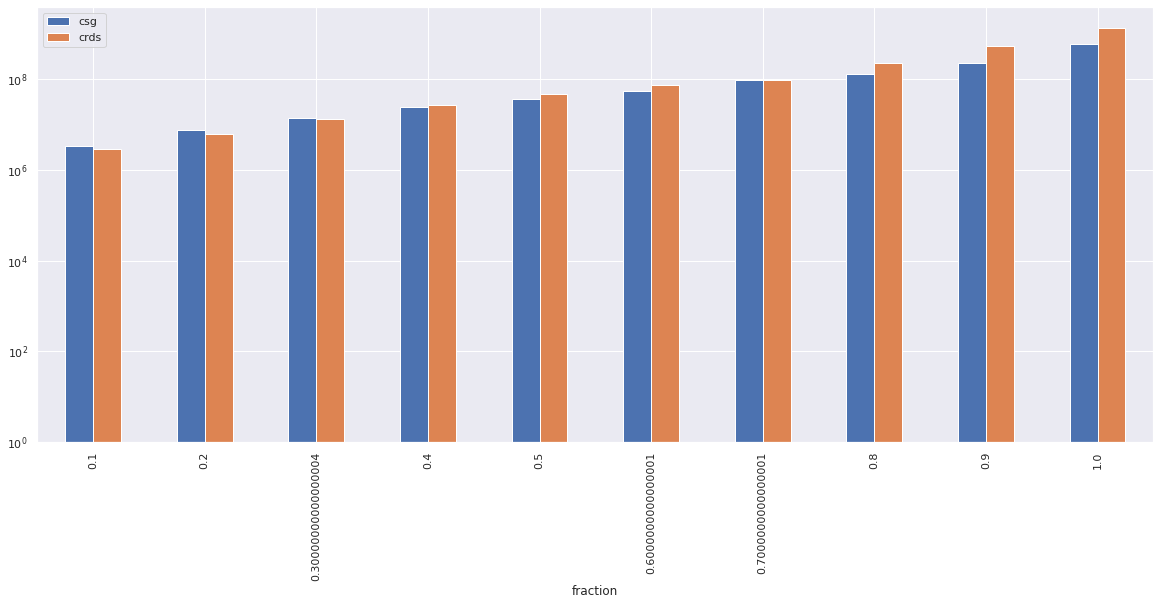

In [78]:
df_quantile_test.plot.bar(x="fraction", y=["csg", "crds"], rot=90, log=True)

In [79]:
logger.info(
    f"Temps d'exécution du Notebook, y compris les imports : {timeit.default_timer() - debut_global} s"
)

[leximpact_socio-fisca-simu-etat INFO @ 15:10:22] Temps d'exécution du Notebook, y compris les imports : 62.06860660016537 s


- Temps d'exécution du Notebook, y compris les imports sur PC Benoît, sans MemoryConfig : 60 secondes
- Temps d'exécution du Notebook, y compris les imports sur PC Benoît, avec MemoryConfig : 67 secondes 
- Temps d'exécution du Notebook, y compris les imports sur PC Benoît, sans MemoryConfig si on ne réutilise plus create_simulation s'il existe déjà, on le refait à chaque fois. : 93 secondes

In [80]:
#!cd .. && make lib